# Overview

## Problem
All Life bank wants to grow its credit card market with insights from their DB. AlsoAll Life Bank is having complaints on the costumer service.

## Solution
Make different clusters out of the database which indicate their characteristics and preferences in terms of contacting the bank. These insights will also show us by which means we can approach new costumers.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_excel('Credit Card Customer Data.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


# EDA

In [3]:
df.drop(['Customer Key', 'Sl_No'], axis=1, inplace=True)
df.replace(0,np.nan).isnull().sum()

Avg_Credit_Limit         0
Total_Credit_Cards       0
Total_visits_bank      100
Total_visits_online    144
Total_calls_made        97
dtype: int64

Originally, there were no null values, just recorded zeros.These zeros are acceptable since they are in columns which it could be logical to have a 0.

# Univariate Analysis

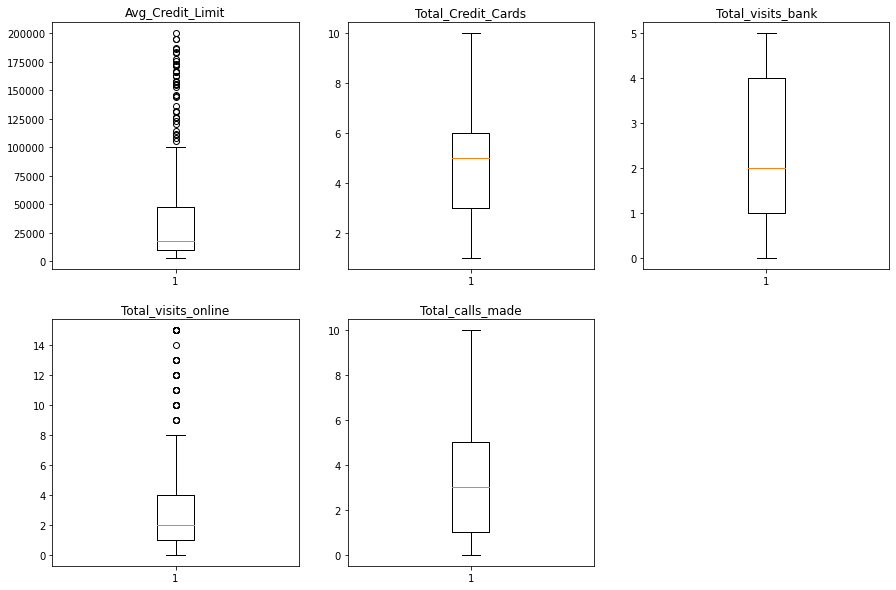

In [4]:
columns = df.columns
plt.subplots(figsize=(15,10))

for i, value in enumerate(columns):    
    plt.subplot(2,3,i+1)
    plt.boxplot(df[value], whis=1.5)
    plt.title(value)
    plt.show

There are a lot of outliers in the credit limit and online visits, but I consider them to be relevant since they are linked to 3 other values which are within good ranges on the rest of the columns.

# Bivariate Analysis

<AxesSubplot:>

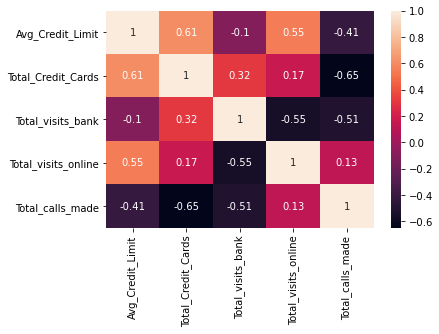

In [5]:
sns.heatmap(df.corr(), annot=True)

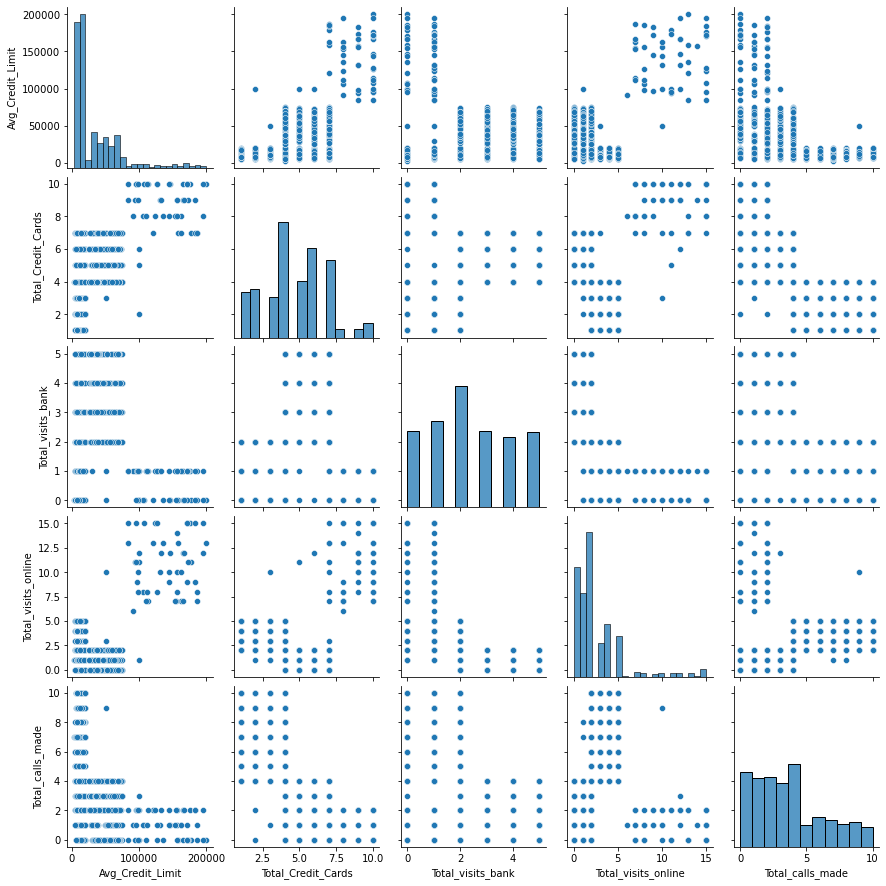

In [6]:
sns.pairplot(df)

# Pre-preocessing

Since there are no outliers or null values worth removing, the pre-processing will only consist in transforming the data into zscores to normalize all the values and have them all weigh the same when building the clusters.

In [7]:
from scipy.stats import zscore
df_scaled = df.apply(zscore)

#Ill also make a copy for the the Hierarchical model
df_scaled2 = df_scaled.copy()

# K-Means Clustering

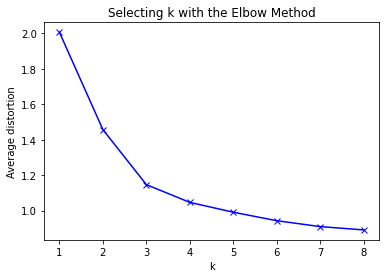

In [8]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(df_scaled)
    prediction = model.predict(df_scaled)
    distortion = (
        sum(
            np.min(cdist(df_scaled, model.cluster_centers_, "euclidean"), axis=1)
        )
        / df_scaled.shape[0]
    )

    meanDistortions.append(distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

Seems like the elbow is somewhere between k values 3 and 4 but ill do the silhouette to verify which is better.

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2717470361089752)
For n_clusters = 6, the silhouette score is 0.255157015683298)
For n_clusters = 7, the silhouette score is 0.24804793526154098)
For n_clusters = 8, the silhouette score is 0.24891810146273655)
For n_clusters = 9, the silhouette score is 0.22157329375045653)


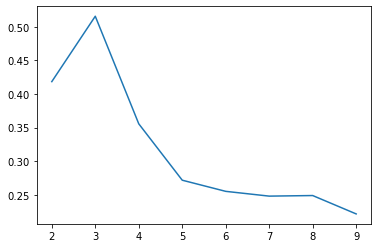

In [9]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((df_scaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_scaled, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

K=3 is the optimal number of clusters

In [10]:
#Ill create num_col to store the column numbers in a list
num_col = df.select_dtypes(include=np.number).columns.tolist()

# Ill define kmeans as a variable with 3 clusters and then fit it with the scaled data
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_scaled)

#Ill create a column with the means segments
df_scaled["Groups"] = kmeans.labels_



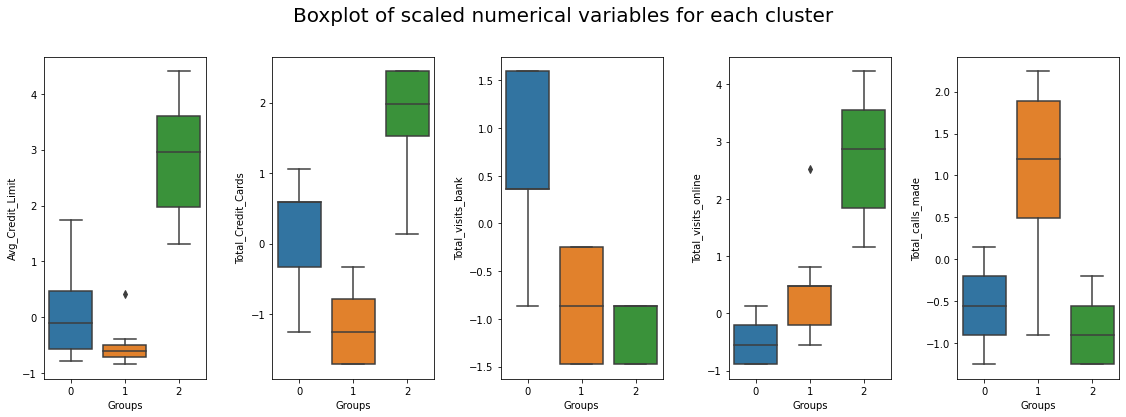

In [11]:
# Ill give form to the graphs which will later be shown
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0

for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df_scaled[num_col[counter]], x=df_scaled["Groups"])
    counter = counter + 1
    
    fig.tight_layout(pad=2.0)
    

In [12]:
#I will create a coloured dataframe to compare with the other model at the end
df_clust2 = df_scaled.groupby(['Groups'])
df_clust2 = df_clust2.mean().style.highlight_max(color="green", axis=0).highlight_min(color="red", axis=0)

# Hierarchical Clustering

In [13]:
# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist


In [17]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_scaled))
   
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

print( "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0], high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9168725782090766, which is obtained with euclidean distance and average linkage.


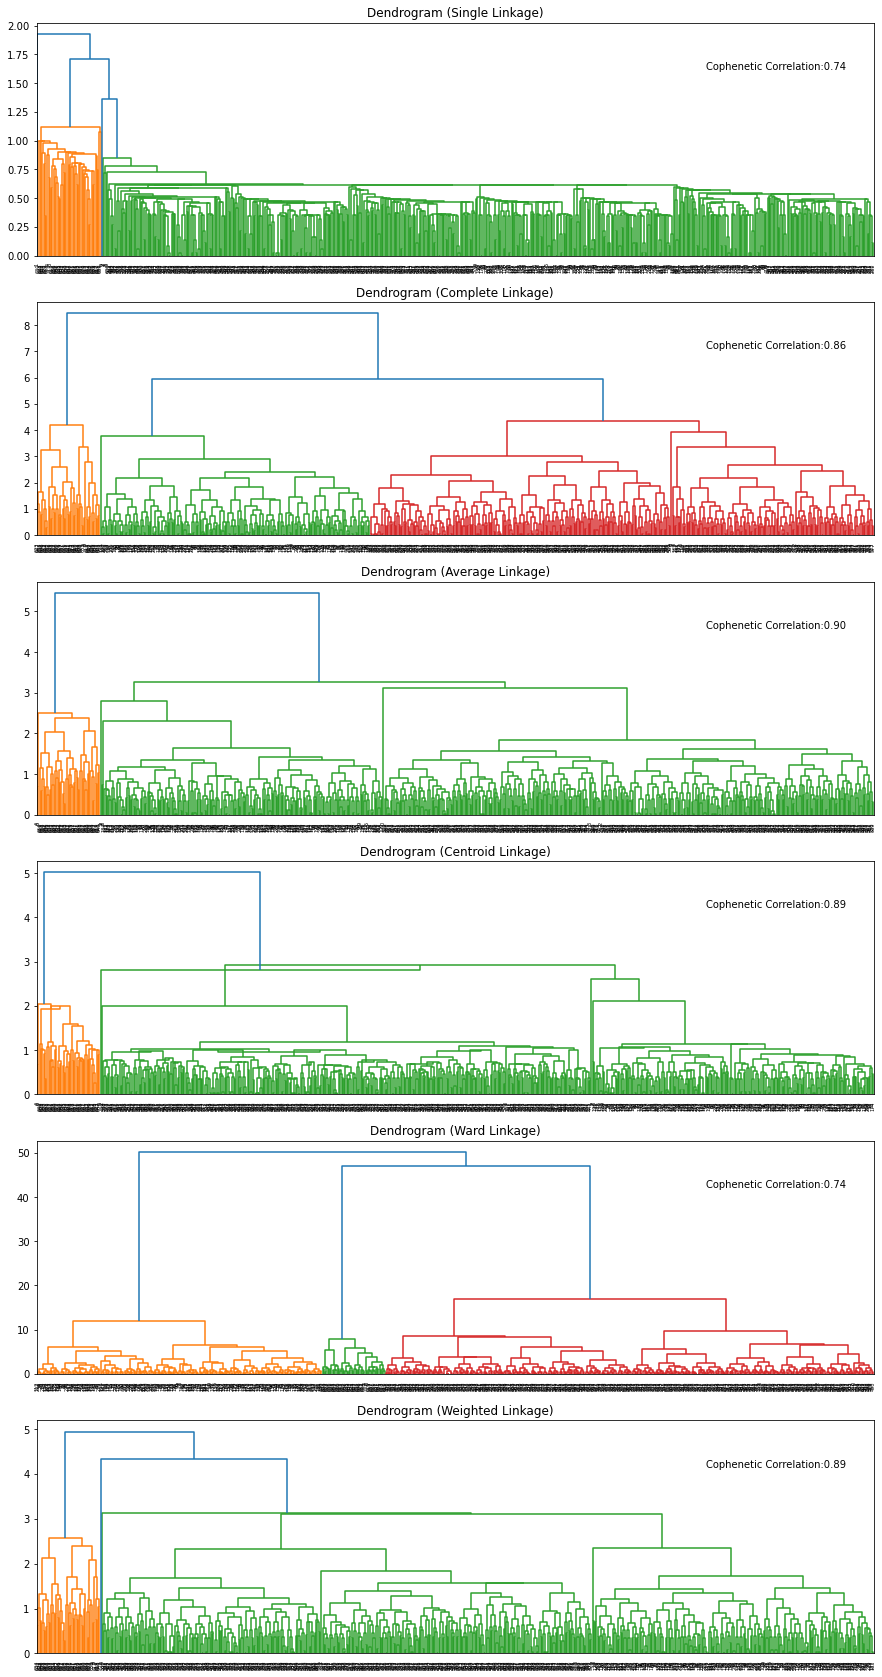

In [18]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient Hier"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

#I will create a dendogram for all the linkage methods within the Euclidean distance which was the best one as we saw before.
for i, method in enumerate(linkage_methods):
    z = linkage(df_scaled2, metric="euclidean", method=method)
    
    dendrogram(z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")
    
    coph_corr, coph_dist = cophenet(z, pdist(df_scaled2))
    axs[i].annotate(f"Cophenetic Correlation:{coph_corr:0.2f}",(0.80, 0.80), xycoords="axes fraction")
    
    compare.append([method, coph_corr])

In [19]:
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient Hier
0,single,0.739122
1,complete,0.859973
2,average,0.897708
3,centroid,0.893939
4,ward,0.741516
5,weighted,0.886175


Average Linkage's Cophenetic Coefficient is the highest value.

In [20]:
#Since the Average Linkage was the best, I will use it
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(df_scaled2)
df_scaled2['Groups'] = HCmodel.labels_
df_clust3 = df_scaled2.groupby(['Groups'])
df_clust3 = df_clust3.mean().style.highlight_max(color="green", axis=0).highlight_min(color="red", axis=0)
df['Groups'] = HCmodel.labels_


In [21]:
#I will create a table of means from the original database to compare it to both models and see what their outputs mean
df_clust4 = df.groupby(['Groups'])
df_clust4 = df_clust4.mean().style.highlight_max(color="green", axis=0).highlight_min(color="red", axis=0)

In [22]:
#Data from K-means
df_clust2

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Groups,,,,,
0,-0.021062,0.373690,0.666395,-0.553672,-0.553005
1,-0.595796,-1.059623,-0.901518,0.322997,1.148109
2,2.831764,1.862226,-1.105763,2.827319,-0.874330


In [23]:
#Data from Hierarchy
df_clust3

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Groups,,,,,
0,-0.022902,0.371882,0.664034,-0.552775,-0.551200
1,2.831764,1.862226,-1.105763,2.827319,-0.874330
2,-0.595179,-1.062913,-0.904453,0.325372,1.152605


In [24]:
#Original data
df_clust4

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Groups,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12197.309417,2.403587,0.928251,3.560538,6.883408


# Conclusion

## Overview of models
Both models turned out to be similar and gave us 3 groups with different characteristics but the same chracteristics across both models. I will address the first Model 'df_clust2' in my insights and recommendations generalizing for both models.

## Insights and Recommendations
#### Cluster 0:
- This cluster is below average in wealthiness having a low credit limit and 5 cards on average per user which means that the user might have dependents. Overall this signifies a below-average income/credit community.
- this community has the highest visits to the bank an on the contrary has very few visits online and few calls as well. This tells us that this cluster should not be targeted for Digital Mkt or for online promotions and to get more costumers from this cluster it would be good to place more establishments amongst these communities.

#### Cluster 1:
- This cluster is the poorest of the DB, they have low score limit and very few cards on average per user.
- This cluster has ~90% of its communication witht the bank through the use of technology (phone or online). Making calls is still the prefered way of engaging for these costumers but their use of technology could be exploited and advertised. Also, the bank should incite costumers to leave the phone call alternative since its so badly correlated with important factors to the bank such as number of credit cards and credit limit. In any case the costumer is to be contacted, it should still be through phone but an A/B testing is recommended for also trying online.
- Digital Mkt could be used in communities with low income to attract new costumers.

#### Cluster 2:
- This cluster is the wealthiest having the highest credit limit and credit cards on average. Family promotions should be done for this cluster given the number of cards they have which resemble a high number of dependents.
- This cluster has 90% of its communication with the bang online, this means that any promo/reminder/deal is most likely to be engaged if it is done online. 

In general, all three clusters have different economic levels and for each of these levels there is a way to approach to better the costumer service and also to pull in more users to the bank